In \[1\]:

    #Import Libraries
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    import re
    from textblob import TextBlob
    import tweepy as tw
    import credentials
    %matplotlib inline

Instantiate the Bert Model

In \[2\]:

    tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
    model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Classes Secction

In \[2\]:

    #Classes for collecting Data and Authentication
    class Twitter_Authentication:
        #Function used to connect with the Twitter API
        def app_authenticate(self):
            auth =tw.OAuthHandler(credentials.API_KEY, credentials.KEY_SECRET)
            auth.set_access_token(credentials.ACCESS_TOKEN,credentials.ACCESS_TOKEN_SECRET)
            return auth

    class Data_collection:
        def __init__(self,user=None):
            au=Twitter_Authentication()
            self.auth =au.app_authenticate()
            self.api = tw.API(self.auth, wait_on_rate_limit=True)
            self.user=user
         
        #Function to search for a specific word, query or hashtag in Twitter and get tweets
        def get_tweets(self,word_to_search,tweets_num,date):
            tweets=tw.Cursor(self.api.search_tweets,q=word_to_search,lang="en",until=date,result_type="mixed").items(tweets_num)
            collected_tweets=[i for i in tweets]
            return collected_tweets
        
        #Function to get tweets from specific user
        def get_tweets_from_user(self,tweets_num):
            tweets=tw.Cursor(self.api.user_timeline,screen_name=self.user).items(tweets_num)
            collected_tweets=[i for i in tweets]
            return collected_tweets

        #Function that used in collecting all the collected data into a Pandas DataFrame
        def tweets_to_DataFrame(self,tweets):
            pre=Data_preprocessing()
            tweets_data=[{
                "tweets":pre.clean_tweets_content(tweet.text),
                "tweet_len":len(tweet.text),
                "date":tweet.created_at,
                "source":tweet.source,
                "likes":tweet.favorite_count,
                "retweets":tweet.retweet_count,
                "No._followers":tweet.user.followers_count,
                "lang":tweet.lang
            } for tweet in tweets]
            
            df=pd.DataFrame(tweets_data)
            return df

In \[3\]:

    #Classes for Dealing with Data, preparing it and analysing it
        
    class Data_preprocessing:
        #Function use for dealing with missing data
        def handle_missing_data(self,df,column,fill_with):
            df[column]=df[column].replace(np.nan,fill_with)
            
        # Function used to remove and clean tweets from special chracters
        def clean_tweets_content(self, tweet):
            return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(RT)", " ", tweet).split())
        
        #This function is used to get the percentage of dataset column
        def get_col_percentage(self,col,df):
            
            total=df[col].value_counts()
            percentage=round(df[col].value_counts(dropna=False,normalize=True)*100,3)
            # or percentage=round((df[col]/df[col].sum())*100,2)
            res=pd.concat([total,percentage],axis=1,keys=["Total No.","Percentage"])
            #res['Percentage'] = res['Percentage'].astype(str) + '%'
            return res


    class Sentiment_Analysis:
        
        def __init__(self,analyze_method):
            self.analyze_method=analyze_method
            
        #Function used for applying sentiment analysis based on the input method "Object"
        def sentiment_analysis_method(self,tweet_content):
            pre=Data_preprocessing()
            try:
                if self.analyze_method == "TextBlob":
                    analysis = TextBlob(pre.clean_tweets_content(tweet_content))
                    if analysis.sentiment.polarity > 0:
                        return 1
                    elif analysis.sentiment.polarity == 0:
                        return 0
                    else:
                        return -1
                    
                elif self.analyze_method =="Bert":
                    tokens = tokenizer.encode(pre.clean_tweets_content(tweet_content), return_tensors='pt')
                    result = model(tokens)
                    return int(torch.argmax(result.logits))+1
                
                else:
                    return 7
            
            except Exception:
                print("Error!!!, Check Your Inputs Again, Please")
                

In \[57\]:

    #Class for Data Visualization

    class Data_Visualization:
        
        #For Plotting Pie Charts
        def plot_pie_chart(self,df,col,lbl,title):
            plt.figure(figsize=(6,6))
            pie=plt.pie(df[col].value_counts(),autopct='%1.1f%%',labels=lbl,rotatelabels =True, 
                    startangle=180,shadow=True,textprops={'fontweight': "bold"})
            plt.title(title,fontweight="bold",fontsize=15)
            plt.setp(pie[1], rotation_mode="anchor", ha="center", va="center")
            for tx in pie[1]:
                rot = tx.get_rotation()
                tx.set_rotation(rot+90+(1-rot//180)*180)
            plt.show()
            
        #For Plotting Bar Plots
        def b_plot(self,df,x,y,title):
            sns.barplot(x = x,y = y,data =df)
            plt.xticks(rotation=45)
            plt.title(title,fontweight="bold",fontsize=15)
            plt.show()
            
        #Time Series Function 
        #"For each date in x axis,
        #it will show the number of the crossponding 
        #feature like No.likes or retweets for example"
        def time_series(self,df,col,date_col):
            time_likes = pd.Series(data=df[col].values, index=pd.to_datetime(df[date_col],utc=False))
            time_likes.plot(figsize=(12, 4), color='r',linewidth=1.5)
            plt.ylabel(col,fontweight="bold",fontsize=10)
            plt.xlabel(date_col,fontweight="bold",fontsize=10)
            plt.show()
            
            


    class Predictions:
        
        #Function to apply Simple Linear Regression
        def SLRegression_and_eval(self,df,feature1,feature2):
            X=df[feature1].values
            Y=df[feature2].values
            x_mean=X.mean()
            y_mean=Y.mean()

            #Formula: ax+b=y
            #Calulating a and b values
            a=sum([(xi-x_mean)*(yi-y_mean) for xi,yi in zip(X,Y)])/sum([(xi-x_mean)**2 for xi in X])
            b=y_mean-(a*x_mean)

            #Getting the Y_pred
            Y_pred=lambda x: a*x+b

            #Plotting the Regression Line
            plt.scatter(X,Y,color="y");
            plt.xlabel(feature1,fontweight="bold",fontsize=10)
            plt.ylabel(feature2,fontweight="bold",fontsize=10)
            plt.plot([X.min(),X.max()],[Y_pred(X.min()),Y_pred(X.max())],color="r")
            plt.scatter(x_mean,y_mean,color="purple",marker="s");
            
            RSS=sum([(yi-Y_pred(xi))**2 for xi,yi in zip(X,Y)])
            TSS=sum([(yi-y_mean)**2 for yi in Y])
            R2_score=1-(RSS/TSS)

            print("RSS={}\nTSS={}\nR2_score={}".format(RSS,TSS,R2_score))
        
        
        #Function For Evaluating Classifiers
        def Display_Scores_clf(self,classifier,X_test, y_test,y_pred,ModelName,labels):
            print(ModelName+" recall score: ", str(round(recall_score(y_test,y_pred ,average='micro'),3)*100)+"%")
            print(ModelName+" precision score: ", str(round(precision_score(y_test,y_pred, average='micro'),3)*100)+"%")
            print(ModelName+" f1 score: ", str(round(f1_score(y_test,y_pred, average='micro'),3)*100)+"%")
            print(ModelName+' Testing Accuracy : ',str(round(accuracy_score(y_test,y_pred),3)*100)+"%")
        

Data Collection and preparation process

In \[30\]:

    #Collecting the tweets process
    d=Data_collection()
    #Specifying a date to get tweets from and before the specified date "maximum a week before"
    date = "2022-01-09"
    s=d.get_tweets("Bitcoin",1000,date)
    #s2=d.get_tweets_from_user(200)

In \[7\]:

    #Constructing the dataset
    df=d.tweets_to_DataFrame(s)

Exploring The Data

In \[8\]:

    df.head()

Out\[8\]:

|     | tweets                                            | tweet_len | date                      | source              | likes | retweets | No.\_followers | lang |
|-----|---------------------------------------------------|-----------|---------------------------|---------------------|-------|----------|----------------|------|
| 0   | Ok ID 10t I m going to school you again not be... | 140       | 2022-01-08 22:44:26+00:00 | Twitter for iPhone  | 21536 | 4350     | 3321072        | en   |
| 1   | Milton Friedman predicting Bitcoin back in 1999   | 74        | 2022-01-08 21:50:08+00:00 | Twitter Web App     | 5004  | 1257     | 1921879        | en   |
| 2   | Happy birthday bitcoin Still not a teen yet ea... | 85        | 2022-01-03 15:23:17+00:00 | Twitter Web App     | 16732 | 3681     | 4838531        | en   |
| 3   | Bitcoin network power slumps as Kazakhstan cra... | 132       | 2022-01-08 23:59:58+00:00 | Twitter for Android | 0     | 59       | 1270           | en   |
| 4   | I am not asking much i just need 1 BitCoin        | 44        | 2022-01-08 23:59:58+00:00 | Twitter Web App     | 5     | 2        | 395            | en   |

In \[9\]:

    df.shape

Out\[9\]:

    (1000, 8)

In \[10\]:

    df.dtypes

Out\[10\]:

    tweets                        object
    tweet_len                      int64
    date             datetime64[ns, UTC]
    source                        object
    likes                          int64
    retweets                       int64
    No._followers                  int64
    lang                          object
    dtype: object

In \[11\]:

    df.describe()

Out\[11\]:

|       | tweet_len   | likes       | retweets     | No.\_followers |
|-------|-------------|-------------|--------------|----------------|
| count | 1000.000000 | 1000.00000  | 1000.000000  | 1.000000e+03   |
| mean  | 121.069000  | 43.95700    | 1131.872000  | 1.341680e+04   |
| std   | 31.852862   | 876.15652   | 3293.789997  | 2.010528e+05   |
| min   | 18.000000   | 0.00000     | 0.000000     | 0.000000e+00   |
| 25%   | 111.000000  | 0.00000     | 0.000000     | 3.400000e+01   |
| 50%   | 139.000000  | 0.00000     | 39.000000    | 1.570000e+02   |
| 75%   | 140.000000  | 0.00000     | 687.000000   | 5.075000e+02   |
| max   | 148.000000  | 21536.00000 | 28830.000000 | 4.838531e+06   |

In \[12\]:

    df.isna().sum()

Out\[12\]:

    tweets           0
    tweet_len        0
    date             0
    source           0
    likes            0
    retweets         0
    No._followers    0
    lang             0
    dtype: int64

In \[13\]:

    #In case, if there is any empty tweets "Empty Strings"
    df.drop(df.index[df.tweets == ""], inplace = True)

Sentiment Analysis

In \[14\]:

    s=Sentiment_Analysis("TextBlob")
    df["TB_Sentiment"]=np.array([s.sentiment_analysis_method(tweet) for tweet in df.tweets])

In \[15\]:

    s2=Sentiment_Analysis("Bert")
    df["Bert_Sentiment"]=np.array([s2.sentiment_analysis_method(str(tweet)) for tweet in df.tweets])

In \[16\]:

    df.head()

Out\[16\]:

|     | tweets                                            | tweet_len | date                      | source              | likes | retweets | No.\_followers | lang | TB_Sentiment | Bert_Sentiment |
|-----|---------------------------------------------------|-----------|---------------------------|---------------------|-------|----------|----------------|------|--------------|----------------|
| 0   | Ok ID 10t I m going to school you again not be... | 140       | 2022-01-08 22:44:26+00:00 | Twitter for iPhone  | 21536 | 4350     | 3321072        | en   | 1            | 3              |
| 1   | Milton Friedman predicting Bitcoin back in 1999   | 74        | 2022-01-08 21:50:08+00:00 | Twitter Web App     | 5004  | 1257     | 1921879        | en   | 0            | 1              |
| 2   | Happy birthday bitcoin Still not a teen yet ea... | 85        | 2022-01-03 15:23:17+00:00 | Twitter Web App     | 16732 | 3681     | 4838531        | en   | 1            | 4              |
| 3   | Bitcoin network power slumps as Kazakhstan cra... | 132       | 2022-01-08 23:59:58+00:00 | Twitter for Android | 0     | 59       | 1270           | en   | 0            | 1              |
| 4   | I am not asking much i just need 1 BitCoin        | 44        | 2022-01-08 23:59:58+00:00 | Twitter Web App     | 5     | 2        | 395            | en   | 1            | 1              |

In \[17\]:

    df.to_csv("bitcoin-twitter.csv",index=False)

In \[90\]:

    df=pd.read_csv("bitcoin-twitter.csv")

In \[91\]:

    #Labeling and changing both Bert and TextBlob Sentiment columns values
    bert_scales={1:"Negative",2:"N_to_N",3:"Neutral",4:"N_to_P",5:"Postive"}
    textblob_scales={-1:"Negative",0:"Neutral",1:"Postive"}
    df["labeled_TB"]=df.TB_Sentiment.map(lambda x:textblob_scales.get(x))
    df["labeled_Bert"]=df.Bert_Sentiment.map(lambda x:bert_scales.get(x))

In \[92\]:

    #Percentage of Bert Column
    d=Data_preprocessing()
    bert_res=d.get_col_percentage("labeled_Bert",df)
    bert_res

Out\[92\]:

|          | Total No. | Percentage |
|----------|-----------|------------|
| Postive  | 515       | 51.5       |
| Negative | 326       | 32.6       |
| Neutral  | 77        | 7.7        |
| N_to_P   | 43        | 4.3        |
| N_to_N   | 39        | 3.9        |

In \[93\]:

    #Visuallizing sentiment analysis 
    vis=Data_Visualization()
    vis.plot_pie_chart(df,"Bert_Sentiment",list(df.labeled_Bert.value_counts().index)
                       ,"Opinions about Bitcoin Topic using Bert")

![](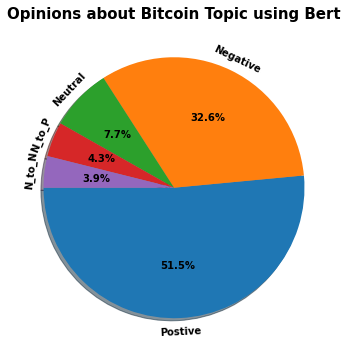%0A)

In \[94\]:

    #Percentage of TextBlob Column
    TB_res=d.get_col_percentage("labeled_TB",df)
    TB_res

Out\[94\]:

|          | Total No. | Percentage |
|----------|-----------|------------|
| Postive  | 540       | 54.0       |
| Neutral  | 413       | 41.3       |
| Negative | 47        | 4.7        |

In \[95\]:

    #Visuallizing sentiment analysis using TextBlob
    vis=Data_Visualization()
    vis.plot_pie_chart(df,"TB_Sentiment",list(df.labeled_TB.value_counts().index)
                       ,"Opinions about Bitcoin Topic using TextBlob")

![](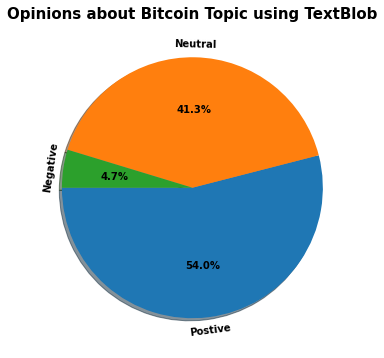%0A)

In \[96\]:

    #Getting the Highest used sources
    '''
    Information like this could be useful in knowing 
    where the most tweets which are related to Bitcion
    Topic comes from  

    '''
    #Getting the highest used sources, collecting them in a DataFrame
    Highest_used_sources=df.source.value_counts()[:3]
    Highest_used_sources=Highest_used_sources.rename_axis('sources').reset_index(name='counts')

    #Getting the remaining used sources
    #collecting and appending them in the previous DataFrame
    remaining_sources=df.source.value_counts()[3:]
    other_sources_total=np.sum(list(remaining_sources))

    #DataFrame Includes all Sources
    all_used_sources =Highest_used_sources.append({"sources":"Other Source","counts":other_sources_total}, ignore_index = True)
    all_used_sources

Out\[96\]:

|     | sources             | counts |
|-----|---------------------|--------|
| 0   | Twitter for Android | 417    |
| 1   | Twitter Web App     | 268    |
| 2   | Twitter for iPhone  | 244    |
| 3   | Other Source        | 71     |

In \[97\]:

    #Now visualize it
    vis.b_plot(all_used_sources,"sources","counts","Tweets Sources")

![](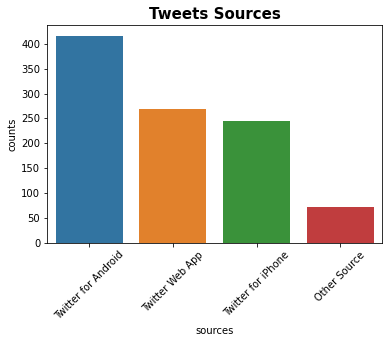%0A)

In \[98\]:

    '''
    This Plot shows that the most number of 
    likes that a tweet talking about bitcoin get
    was between 01-08 and 01-09

    '''
    vis.time_series(df,"likes","date")

![](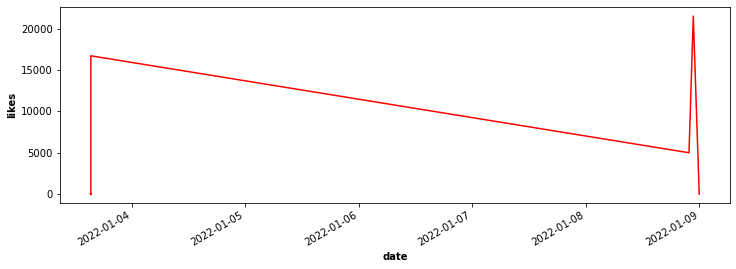%0A)

In \[99\]:

    '''
    This Plot shows that the most number of 
    retweets for a tweet which talking about bitcoin
    was between 01-03 and 01-04

    '''
    vis.time_series(df,"retweets","date")

![](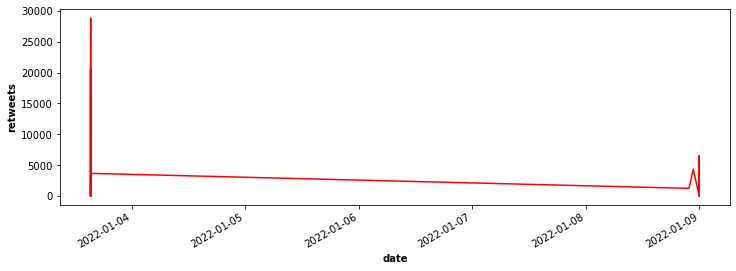%0A)

Conclusions

In \[100\]:

    print("#Number of Likes for the most liked tweet was: ",df.likes.max())
    print("#Average Number of the retweets: ",df.retweets.mean())
    print("#The most used source was: ",all_used_sources.sources[0])
    print("#The Average Number of likes between all tweets was: ",df.likes.mean())
    print("#From Previous Sentiment Analysis Results:\n",
          "Both Bert model and TextBlob models prove that:\n",
          "Most of opinions about bitcoin between 2022-01-03 to 2022-01-09",
          "\n were Positive"
         )

    print("\n#Bert_Results:\n",
          "Negative: {}%".format(bert_res.Percentage[1]),
          "\nNegative to Neutral: {}%".format(bert_res.Percentage[4]),
          "\nNeutral: {}%".format(bert_res.Percentage[2]),
          "\nNeutral to Postive: {}%".format(bert_res.Percentage[3]),
          "\nPostive: {}%".format(bert_res.Percentage[0]),
          "\n\n#TextBlob_Results:\n",
          "Negative: {}%".format(TB_res.Percentage[2]),
          "\nNeutral: {}%".format(TB_res.Percentage[1]),
          "\nPostive: {}%".format(TB_res.Percentage[0]),
         )

    #Number of Likes for the most liked tweet was:  21536
    #Average Number of the retweets:  1131.872
    #The most used source was:  Twitter for Android
    #The Average Number of likes between all tweets was:  43.957
    #From Previous Sentiment Analysis Results:
     Both Bert model and TextBlob models prove that:
     Most of opinions about bitcoin between 2022-01-03 to 2022-01-09 
     were Positive

    #Bert_Results:
     Negative: 32.6% 
    Negative to Neutral: 3.9% 
    Neutral: 7.7% 
    Neutral to Postive: 4.3% 
    Postive: 51.5% 

    #TextBlob_Results:
     Negative: 4.7% 
    Neutral: 41.3% 
    Postive: 54.0%

Predictive data analysis (PDA) Section

In \[101\]:

    #Normalizing values in Numerical columns 
    normalized_df=(df-df.mean())/df.std()

    #getting a subset of the normalizied data set
    # Preparing it for Regression
    normalized_df=normalized_df[["likes","retweets","No._followers"]]
    normalized_df.head()

Out\[101\]:

|     | likes     | retweets  | No.\_followers |
|-----|-----------|-----------|----------------|
| 0   | 24.529913 | 0.977029  | 16.451674      |
| 1   | 5.661138  | 0.037989  | 9.492343       |
| 2   | 19.046874 | 0.773919  | 23.999239      |
| 3   | -0.050170 | -0.325726 | -0.060416      |
| 4   | -0.044464 | -0.343031 | -0.064768      |

In \[102\]:

    #There is a poor correlation between likes and retweets
    #Thus, they might be independent 
    #normalized_df.likes.corr(normalized_df["retweets"])

    #There is a High correlation between likes and user Number of followers
    #So, that may help when we start using simple linear regression 
    normalized_df.likes.corr(normalized_df["No._followers"])

Out\[102\]:

    0.918370877530643

In \[103\]:

    p=Predictions()
    p.SLRegression_and_eval(normalized_df,"No._followers","likes")

    RSS=156.43833637229085
    TSS=999.0000000000337
    R2_score=0.8434050686964109

![](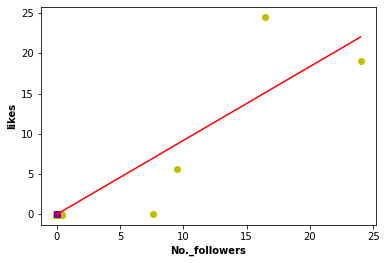%0A)

In \[104\]:

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

    #Example for a Multiclass classification problem
    selected_features=["likes","retweets","tweet_len","No._followers"]
    x=df[selected_features]
    y=df['TB_Sentiment']
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

    #Standard scaler used for scaling the columns values 
    #because there is a big difference
    sc = StandardScaler()
    x_train=sc.fit_transform(x_train)
    x_test=sc.transform(x_test)

In \[105\]:

    #Testing Random Forest Classifier 
    rfc=RandomForestClassifier()
    rfc.fit(x_train,y_train)
    ypred2=rfc.predict(x_test)
    labels=["Negative","Neutral","Positive"]
    #Evaluate The Accuracy of the Classifier
    p.Display_Scores_clf(rfc, x_test, y_test,ypred2,'Random Forest Classifier',labels)

    Random Forest Classifier recall score:  71.5%
    Random Forest Classifier precision score:  71.5%
    Random Forest Classifier f1 score:  71.5%
    Random Forest Classifier Testing Accuracy :  71.5%

\begin{eqnarray\*} Metric:\\,\\, Accuracy =& \frac{tp+tn}{N} \\,\\,,
Recall =& \frac{tp}{tp+fn} \\,\\,, Percision =& \frac{tp}{tp+fp} \\,\\,,
F1 Score =& 2\*\frac{perscision\*recall}{perscision+recall}
\end{eqnarray\*}

In \[ \]: